<a href="https://colab.research.google.com/github/23f1000208/Physics-Inspired-Machine-Learning/blob/main/CH_4_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 🧭 How to Use This Notebook
* 🔽 **Work top-to-bottom.** Read the explanations, then run each code cell by clicking the play button ▶️
* 💡 **Don’t worry if you don’t understand everything immediately.** Machine learning takes practice!


# ✨ Logistic Regression

## Abstract

Logistic Regression is a foundational (and surprisingly powerful) method for **binary classification**: it learns a linear combination of features and maps it through the **sigmoid function** to produce **probabilities**. Because its predictions are probabilistic and its parameters are interpretable, it’s especially well-suited for real-world decisions where the cost of errors matters—not just the overall accuracy.

Using the **Breast Cancer Wisconsin (Diagnostic) Dataset** (569 samples, 30 numeric features from FNA images, benign vs malignant labels), this notebook walks through an end-to-end, best-practice workflow for training, evaluating, tuning, and interpreting logistic regression with scikit-learn—while emphasizing disciplined validation and clinically meaningful metrics.

🚀 **By the end of this notebook, you will** build a leakage-safe logistic regression pipeline, evaluate it with medical-relevant metrics, choose a decision threshold aligned with screening goals, and interpret model coefficients as feature impacts on cancer risk.

**In this notebook, we will:**
- Install required libraries and import packages needed for the full workflow  
- Load the Breast Cancer dataset (via `load_breast_cancer`) and set up a reproducible notebook structure  
- Build a working pandas DataFrame/Series and run sanity checks (shape, dtypes, class balance)  
- Perform basic EDA to understand signal, separability, and why feature scaling matters 📊  
- Create a **stratified** train/test split with fixed randomness to preserve class proportions and reproducibility  
- Develop intuition for logistic regression: scores → sigmoid probabilities → thresholded decisions  
- Explain log loss (maximum likelihood), regularization, and iterative optimization conceptually  
- Prevent data leakage with **StandardScaler + Pipeline** and train a baseline logistic regression model  
- Evaluate performance with clinically meaningful metrics: confusion matrix, sensitivity/recall, specificity, precision, F1, ROC-AUC (and PR curves when helpful) 🧪  
- Explore **decision thresholding** to select an operating point that reflects screening trade-offs (e.g., minimizing false negatives)  
- Use **stratified cross-validation** to estimate performance robustly and compare to the holdout test set  
- Compare regularization choices (L2 vs L1), understand solver constraints, and apply `class_weight` for cost-sensitive learning ⚖️  
- Tune hyperparameters with **GridSearchCV** using an objective-aligned scoring metric—keeping the test set for final, single-use reporting  
- Check probability reliability via calibration curves and Brier score; optionally calibrate probabilities for risk-based decisions 🎯  
- Interpret standardized coefficients as **log-odds** (and odds ratios), rank influential features, and discuss multicollinearity effects  
- Conduct error analysis (false positives/negatives, borderline cases) to guide thresholding and modeling choices  
- Select a final model, retrain properly, and report test-set results with a clear rationale for the chosen operating point  
- Extend and compare to alternatives (linear SVM, simple tree baseline), highlighting interpretability, calibration, and decision control 🔍


## 🛠️ Setup

In this course, we will use a few Python packages. Run the following cell to make sure they are installed.


In [ ]:
!pip -q install numpy pandas scikit-learn matplotlib seaborn



---

## 📦 Imports

Let's also import all the packages that we need during the course.



In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    brier_score_loss
)

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

np.random.seed(42)


In [ ]:

## set the color themes of the figures
import requests
style = requests.get("https://compu-flair.com/notes/jupyter-color-style/raw").text
exec(style)

## ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")


<string>:134: AltairDeprecationWarning: 
Deprecated since `altair=5.5.0`. Use altair.theme instead.
Most cases require only the following change:

    # Deprecated
    alt.themes.enable('quartz')

    # Updated
    alt.theme.enable('quartz')

If your code registers a theme, make the following change:

    # Deprecated
    def custom_theme():
        return {'height': 400, 'width': 700}
    alt.themes.register('theme_name', custom_theme)
    alt.themes.enable('theme_name')

    # Updated
    @alt.theme.register('theme_name', enable=True)
    def custom_theme():
        return alt.theme.ThemeConfig(
            {'height': 400, 'width': 700}
        )

See the updated User Guide for further details:
    https://altair-viz.github.io/user_guide/api.html#theme
    https://altair-viz.github.io/user_guide/customization.html#chart-themes


## 📊 Data

In this course, we will work with the **Breast Cancer Wisconsin (Diagnostic) Dataset** dataset and would like to use **Logistic Regression** to **classify whether a tumor is malignant or benign**. We will discuss dataset's details later. For now, let's just load the data.

We load the dataset directly from scikit-learn using `load_breast_cancer`, which returns the feature matrix **X** and the binary target labels **y**.

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

# Load the dataset in its original scikit-learn structure (Bunch)
dataset = load_breast_cancer()

# Also get X and y as provided (features and target)
X, y = load_breast_cancer(return_X_y=True)

# Convert to a DataFrame for easy display (keeps original dataset intact above)
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df["target"] = dataset.target

# Display the dataset (DataFrame preview)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0



## 🔍 Inspecting the Dataset Object

Before we dive into the data itself, let's inspect the object we just loaded. This will help us understand how the data is stored and where to find important information like the dataset description or feature names.


In [ ]:
# Inspect dataset object metadata storage
print("Type:", type(dataset))

if hasattr(dataset, "keys"):
    keys = list(dataset.keys())
    print("Keys:", keys)
    print("'DESCR' present:", "DESCR" in keys)
    if "DESCR" in keys:
        print("\nDESCR preview:\n", dataset["DESCR"][:500])
else:
    print("No .keys() method found on dataset object.")

Type: <class 'sklearn.utils._bunch.Bunch'>
Keys: ['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module']
'DESCR' present: True

DESCR preview:
 .. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (


## 📚 Learn more about data

🔎 **We always want to learn the column names of dataset and what they actually mean (attribute information)**

The **feature (column) names** are stored in `dataset.feature_names`, and the actual **feature values** are in `dataset.data` (or `X` if you used `return_X_y=True`). The **target labels** are in `dataset.target` (or `y`), the **target class names** are in `dataset.target_names`, and the **human-readable descriptions/attribute information** are in `dataset.DESCR`.

In [ ]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()

# Full dataset description (includes feature and target info)
print(dataset["DESCR"])

# Feature names
print("\nFeature names (n={}):".format(len(dataset.feature_names)))
for i, name in enumerate(dataset.feature_names):
    print(f"{i:2d}: {name}")

# Target names and basic target info
print("\nTarget info:")
print("Target names:", list(dataset.target_names))
print("Target values (unique):", sorted(set(dataset.target)))

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

## 🎯 Course Goal, Clinical Framing & Setup

In this notebook, the objective is to train a **logistic regression** model to classify tumors as **malignant vs. benign**. This is a common baseline approach for medical screening tasks where we want a model that is both interpretable and easy to evaluate.

### Clinical framing: why error types matter
Not all mistakes have the same real-world impact in screening:
- **False negative (malignant predicted as benign):** a missed malignancy, typically the most costly error because it can delay diagnosis and treatment.
- **False positive (benign predicted as malignant):** usually leads to additional testing or follow-up—undesirable, but often less harmful than missing a cancer.

This framing will guide how we think about evaluation later (e.g., which errors we are most motivated to reduce).

### Workflow discipline: keep evaluation honest
To make results trustworthy and reproducible, we establish two key practices:
- **Do not touch the held-out test set** until final evaluation. Use training data (and cross-validation) for model development decisions.
- **Fix randomness with a constant seed (`RANDOM_STATE`)** so that data splitting and model results can be reproduced consistently.

### Class encoding
The notebook also confirms the **class label mapping** (e.g., `0 → malignant`, `1 → benign`) and prints it for clarity. Getting this mapping right is essential so that evaluation metrics and clinical interpretation match the true meaning of each label.

In [ ]:
# Objective: predict malignant vs benign tumors using logistic regression.
# Clinical framing: false negatives (missed malignancies) are typically costlier than false positives (extra follow-up).
# Workflow discipline: keep a held-out test set untouched until the end; use CV on training only; fix seeds.

TARGET_COL = "target"

# Attempt to attach human-readable class names if dataset Bunch exists
class_names = None
if "dataset" in globals() and hasattr(dataset, "target_names"):
    class_names = list(dataset.target_names)
else:
    # Default for this dataset: 0=malignant, 1=benign
    class_names = ["malignant", "benign"]

print("Goal: Train a logistic regression classifier to predict tumor class.")
print("Class encoding assumed:")
for i, name in enumerate(class_names):
    print(f"  {i} -> {name}")

print("\nReproducibility:")
RANDOM_STATE = 42
print("RANDOM_STATE =", RANDOM_STATE)


Goal: Train a logistic regression classifier to predict tumor class.
Class encoding assumed:
  0 -> malignant
  1 -> benign

Reproducibility:
RANDOM_STATE = 42


## 🧱 Build a Working DataFrame from the Loaded Dataset

In this step, we turn the loaded dataset into a consistent, analysis-ready structure:

- **Confirm we’re working with a pandas DataFrame.** Many plotting and inspection workflows assume tabular data with column names, so this check prevents silent errors later.
- **Identify the target (label) column and separate it from the features.** We build:
  - **`X`**: the feature matrix (all input columns)
  - **`y`**: the target vector (the output/label column)
- **Capture human-readable names.** Keeping `feature_names` and `target_name` makes it easier to interpret plots, summaries, and model outputs.

Finally, we run quick **sanity checks** that validate the dataset looks like the Breast Cancer Wisconsin dataset:
- Around **569 samples**
- Exactly **30 features**
- A printed **target class distribution** (counts of 0 vs 1) to ensure labels are present and not unexpectedly imbalanced or missing

In [ ]:
# Ensure we have df with features + target and set up X/y consistently.

if not isinstance(df, pd.DataFrame):
    raise TypeError("Expected `df` to be a pandas DataFrame at this point.")

if TARGET_COL not in df.columns:
    # Try to infer target column if not present
    possible_targets = [c for c in df.columns if c.lower() in ("target", "label", "y")]
    if possible_targets:
        TARGET_COL = possible_targets[0]
    else:
        raise RuntimeError("No target column found in `df`. Expected a column named 'target'.")

feature_cols = [c for c in df.columns if c != TARGET_COL]
X = df[feature_cols].to_numpy()
y = df[TARGET_COL].to_numpy()

feature_names = feature_cols
target_name = TARGET_COL

print("Samples:", df.shape[0])
print("Features:", len(feature_cols))
print("Expected (Breast Cancer Wisconsin): ~569 samples, 30 features")
print("Target distribution (0/1 counts):")
print(pd.Series(y).value_counts().sort_index())


Samples: 569
Features: 30
Expected (Breast Cancer Wisconsin): ~569 samples, 30 features
Target distribution (0/1 counts):
0    212
1    357
Name: count, dtype: int64


## 💡 Interpretation of the results

- The target distribution reveals a modest class imbalance: 212 samples belong to class 0 and 357 to class 1. The per-class counts are shown as a pandas Series named count, confirming that labels exist and are represented.
- Takeaway: the data are suitable for binary classification, but the imbalance (more class 1) is something to keep in mind when training and evaluating models.

## 🔍 Data Understanding & Basic Quality Checks

Before modeling, it’s essential to confirm that the dataset looks the way we think it does and that the target label is correctly represented. This step performs a quick but high-impact set of checks that catch common issues early and build confidence in the data.

**What we verify here:**
- **Dataset size and structure:** Check the number of rows and columns to understand how much data we’re working with.
- **Data types (dtypes):** Confirm columns are stored as expected (e.g., numeric features are truly numeric), since incorrect types can break preprocessing or distort results.
- **Feature distributions via summary statistics:** Review counts, means, standard deviations, and percentiles to spot obvious anomalies (e.g., impossible values, extreme outliers, or constant/near-constant features).
- **Missing values:** Identify whether any columns have nulls and how severe the issue is, since missingness affects both preprocessing choices and model behavior.
- **Duplicate rows:** Detect repeated records that could bias training and evaluation if left in place.
- **Class balance:** Inspect how many malignant vs. benign examples are present and their proportions. A skewed class distribution can make accuracy misleading and may require special care.
- **Label sanity check:** Confirm the target column contains only the expected encoded values (e.g., `0` and `1`) and map them to the intended class names.
- **Plausibility of feature values:** Spot-check min/max for a few features to ensure values look like realistic numeric measurements rather than corrupted entries.

**Key takeaway:** these checks help ensure the dataset is clean, correctly labeled, and numerically sensible—reducing the risk of silent errors and misleading model performance later.

In [ ]:
print("df.shape:", df.shape)
print("\nDtypes (first 10):")
print(df.dtypes.head(10))

print("\nSummary statistics (features):")
display(df[feature_cols].describe().T)

missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (top):")
print(missing.head(10))

dup_count = df.duplicated().sum()
print("\nDuplicate rows:", int(dup_count))

print("\nClass balance:")
class_counts = df[TARGET_COL].value_counts().sort_index()
class_props = df[TARGET_COL].value_counts(normalize=True).sort_index()
print(pd.DataFrame({"count": class_counts, "proportion": class_props}).rename(index={0: class_names[0], 1: class_names[1]}))

print("\nLabel sanity check (unique values):", sorted(df[TARGET_COL].unique().tolist()))
print("Feature value plausibility check (min/max of a few columns):")
for c in feature_cols[:5]:
    print(f"  {c}: min={df[c].min():.3g}, max={df[c].max():.3g}")


df.shape: (569, 31)

Dtypes (first 10):
mean radius               float64
mean texture              float64
mean perimeter            float64
mean area                 float64
mean smoothness           float64
mean compactness          float64
mean concavity            float64
mean concave points       float64
mean symmetry             float64
mean fractal dimension    float64
dtype: object

Summary statistics (features):


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744



Missing values (top):
mean radius               0
mean texture              0
mean perimeter            0
mean area                 0
mean smoothness           0
mean compactness          0
mean concavity            0
mean concave points       0
mean symmetry             0
mean fractal dimension    0
dtype: int64

Duplicate rows: 0

Class balance:
           count  proportion
target                      
malignant    212    0.372583
benign       357    0.627417

Label sanity check (unique values): [0, 1]
Feature value plausibility check (min/max of a few columns):
  mean radius: min=6.98, max=28.1
  mean texture: min=9.71, max=39.3
  mean perimeter: min=43.8, max=188
  mean area: min=144, max=2.5e+03
  mean smoothness: min=0.0526, max=0.163


## 💡 Interpretation of the results

The per-feature summary statistics give you a quick sense of central tendency and variability. For instance, the mean of the radius feature is about 14.13 with a standard deviation near 3.52, and the values span roughly from 7 up to 28. These ranges suggest plausible, non-degenerate measurements and help you spot potential outliers or unusually constant features across the dataset.

Missing values and duplicates checks are performed to assess data quality before modeling. Duplicates are counted, which informs whether deduplication might be necessary to avoid biased training or evaluation.

Class balance is displayed as a table of counts and proportions, with the target column renamed to readable class names. This helps you gauge whether the two classes are represented roughly evenly or if there is imbalance that could affect training, sampling, or evaluation strategies.

A label sanity check lists the unique values of the target, ensuring the target encoding matches expectations (e.g., a small set of distinct classes). Plausibility checks for the first five features report their minimum and maximum values, reinforcing that the measurements look reasonable and not obviously corrupted.

## 🔎 Exploratory Data Analysis (EDA) for Signal & Scale

In this step, we build intuition about **which features carry useful signal for separating the classes** and whether the data contains **potential outliers or unusual shapes** that could affect modeling.

### What we’re looking at
- **Feature distributions by class:** For a handful of informative features, we plot smoothed distributions (KDEs) **separately for each class**.  
  - If the class curves are clearly shifted apart, that feature likely provides **strong separability**.  
  - If the curves heavily overlap, the feature may be **less discriminative on its own**.  
  - Odd tails, multiple peaks, or extreme spread can hint at **outliers** or non-uniform patterns worth noting.

### Why scale matters
- **Raw feature scales can differ dramatically.** We summarize the **mean and standard deviation** of every feature and rank them by standard deviation.
- When some features vary on much larger numeric scales than others, many ML algorithms can become **dominated by high-scale features** unless we apply **standardization/normalization**.

### Key takeaway
This quick EDA helps you identify (1) features with visible class separation and (2) large scale differences that motivate **scaling features before training models**.

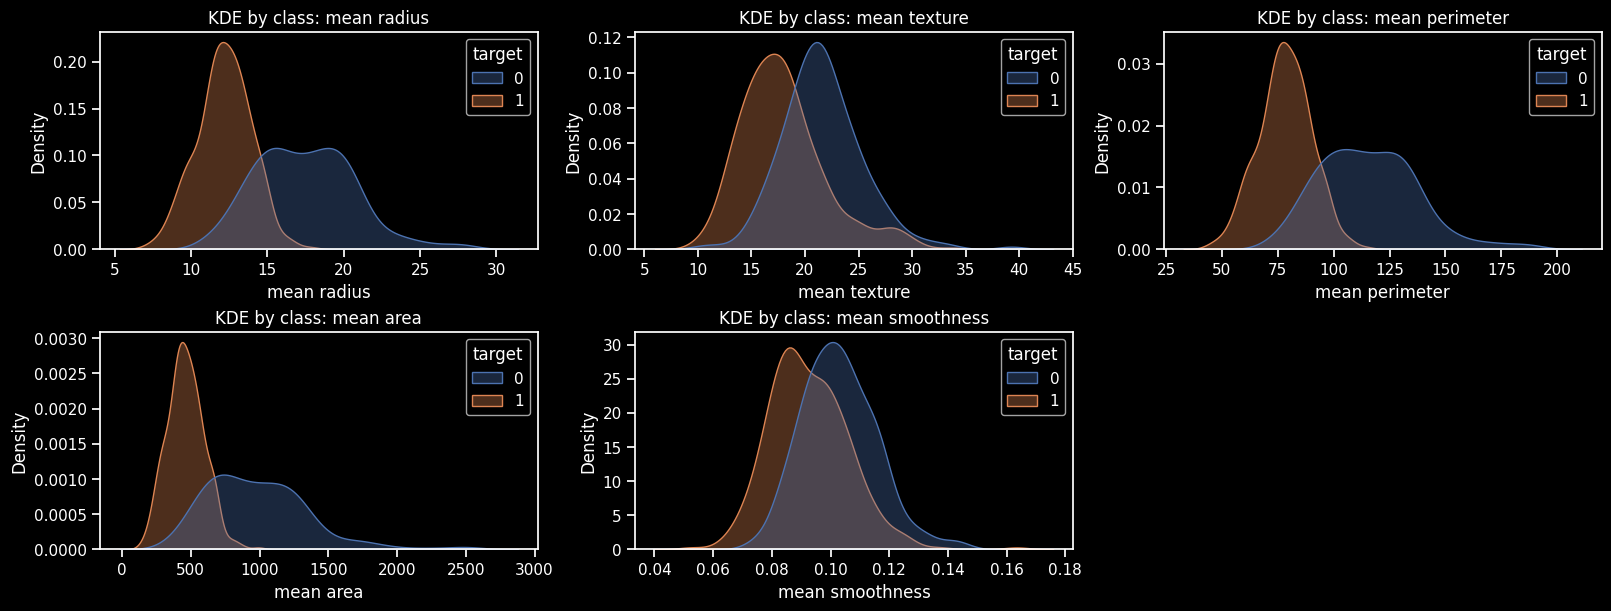

Top 10 features by raw-scale standard deviation (motivates standardization):


,mean,std
worst area,880.583128,569.356993
mean area,654.889104,351.914129
area error,40.337079,45.491006
worst perimeter,107.261213,33.602542
mean perimeter,91.969033,24.298981
worst texture,25.677223,6.146258
worst radius,16.269190,4.833242
mean texture,19.289649,4.301036
mean radius,14.127292,3.524049
perimeter error,2.866059,2.021855


In [ ]:
# Plot distributions for a few informative-looking features and show class-conditional separation.

selected_features = [
    "mean radius",
    "mean texture",
    "mean perimeter",
    "mean area",
    "mean smoothness",
]
selected_features = [c for c in selected_features if c in df.columns]
if len(selected_features) < 3:
    selected_features = feature_cols[:5]

fig, axes = plt.subplots(2, max(2, len(selected_features)//2 + len(selected_features)%2), figsize=(16, 6), constrained_layout=True)
axes = np.array(axes).ravel()
for ax, col in zip(axes, selected_features):
    sns.kdeplot(data=df, x=col, hue=TARGET_COL, common_norm=False, fill=True, alpha=0.35, ax=ax)
    ax.set_title(f"KDE by class: {col}")

for ax in axes[len(selected_features):]:
    ax.axis("off")

plt.show()

# Show scale differences across features (std dev on raw scale)
scale_df = df[feature_cols].agg(["mean", "std"]).T.sort_values("std", ascending=False)
print("Top 10 features by raw-scale standard deviation (motivates standardization):")
display(scale_df.head(10))


## 💡 Interpretation of the results

The cell produced a visualization and accompanying statistics to assess how the selected features relate to the class label. The figure is built with six subplots (one per feature) that display density estimates (KDE) for each class. The plotting code uses six axes in anticipation of up to six features; if there are fewer features available, the unused axes are left off. In this run, five features are shown: mean radius, mean texture, mean perimeter, mean area, and mean smoothness.

From the KDEs, the separability of classes varies by feature. Mean radius and mean area show strong separation between the classes, meaning their distributions for the two classes are largely distinct. Mean perimeter also exhibits noticeable, though not complete, separation. Mean texture and mean smoothness display substantial overlap between classes, indicating weaker discriminative power when viewed in isolation. The legend confirms class colors and the shading highlights regions with higher density of observations.

Separately, the notebook prints a summary titled “Top 10 features by raw-scale standard deviation (motivates standardization)” along with two representations of the same information. The table lists features with their raw mean and standard deviation, highlighting that some features vary dramatically in raw scale. Across features, the most variable ones are area-related: worst area and mean area, followed by area error, worst perimeter, and mean perimeter. This pattern indicates substantial scale differences among features, which can distort learning if not addressed.

Integrating the visuals and the statistics, you see a complementary story: visually strong discriminators (like mean radius and mean area) offer meaningful signals, while other features contribute less on their own but may still help in combination. At the same time, the numeric evidence of large raw-scale variation motivates standardization so that high-scale features do not dominate model training, ensuring that weaker features still contribute meaningfully.

## 🧪 Train/Test Split with Stratification & Reproducibility

To evaluate a model honestly, we need data that the model has **never seen during training**. This step creates a **holdout test set** (20% of the data) and a **training set** (the remaining 80%). The model will learn patterns only from the training set, while the test set is reserved for an unbiased final check of performance.

### Why stratify?
When the target classes are imbalanced, a random split can accidentally produce a test set with very different class proportions than the full dataset. **Stratification** ensures the train and test splits preserve the **same class distribution** as the original target, making evaluation more reliable and comparable.

The printed class proportions confirm that both splits contain similar percentages of each class.

### Why fix `random_state`?
Data splitting involves randomness. Setting a fixed `random_state` makes the split **reproducible**, meaning you (and others) will get the **same train/test partition** every time you run the notebook—crucial for debugging, comparison, and consistent results.

### Key rule: keep the test set untouched
The test set should remain **completely unused** during model development (including feature decisions and tuning). Using it early can leak information and lead to overly optimistic performance estimates.

In [ ]:
X = df[feature_cols]
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

print("\nTrain class proportions:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nTest class proportions:")
print(y_test.value_counts(normalize=True).sort_index())


Train shapes: (455, 30) (455,)
Test shapes: (114, 30) (114,)

Train class proportions:
target
0    0.373626
1    0.626374
Name: proportion, dtype: float64

Test class proportions:
target
0    0.368421
1    0.631579
Name: proportion, dtype: float64


## 💡 Interpretation of the results

- The cell shows a stratified train/test split on a dataset with 569 samples and 30 features, yielding 455 training samples and 114 test samples, with corresponding target vectors aligned in length.
- The split preserves a binary target with two classes (0 and 1): in training, about 37.36% are class 0 and 62.64% are class 1; in testing, about 36.84% are class 0 and 63.16% are class 1.
- The close alignment of class proportions between the train and test sets indicates a successful stratification, meaning the test evaluation will be representative of the dataset’s class distribution. Any tiny differences arise from rounding and finite sample effects.
- Key takeaway: you can trust the test results to reflect performance on the underlying class distribution because the split maintains proportional representation of both classes.

## 🎲 (Optional) Physics-Inspired Logistic Regression

While the rest of this course is independent of physics-inspired concepts, the following video (and its transcript) are **recommended** to gain deeper intuition about the underlying ideas

https://compu-flair.com/physics-inspired-ml/Physics-ML-Series-10

https://youtu.be/IHmffz_81Ps


## 📈 Logistic Regression Intuition: Scores, Probabilities, Decisions

Logistic regression starts by computing a **linear score** for each example:

- **score = w·x + b**

This score can be any real number (negative, zero, or positive). On its own, it isn’t a probability, so we pass it through the **sigmoid function**, which smoothly maps scores into the range **0 to 1**. The plot in this cell shows that:

- large negative scores → probabilities close to **0**
- score **0** → probability **0.5**
- large positive scores → probabilities close to **1**

This is the key idea: **the model’s coefficients (w and b) define a linear separation in feature space**, but instead of outputting a hard class label, logistic regression naturally outputs a **probability** $P(y=1)$.

To convert probabilities into decisions, we apply a **threshold** (commonly **0.5**): predict class 1 when $P(y=1) \ge 0.5$. In this dataset, **y=1 typically denotes benign** and **y=0 malignant**, so the probability output can be interpreted as “how confident the model is that a case is benign,” which is often more useful for real decision-making than a yes/no label alone.

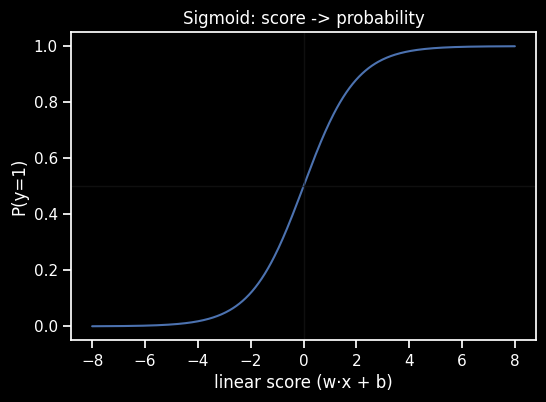

Decision rule at threshold t=0.5: predict 1 if P(y=1) >= 0.5.
In this dataset, y=1 typically denotes benign and y=0 malignant.


In [ ]:
# Demonstrate sigmoid mapping from linear scores to probabilities.

def sigmoid(z):
    z = np.asarray(z)
    return 1 / (1 + np.exp(-z))

z_demo = np.linspace(-8, 8, 400)
p_demo = sigmoid(z_demo)

plt.figure(figsize=(6, 4))
plt.plot(z_demo, p_demo)
plt.axvline(0, color="k", linewidth=1, alpha=0.6)
plt.axhline(0.5, color="k", linewidth=1, alpha=0.6)
plt.title("Sigmoid: score -> probability")
plt.xlabel("linear score (w·x + b)")
plt.ylabel("P(y=1)")
plt.show()

print("Decision rule at threshold t=0.5: predict 1 if P(y=1) >= 0.5.")
print("In this dataset, y=1 typically denotes benign and y=0 malignant.")


## 💡 Interpretation of the results

- This plot illustrates how a linear score is transformed into a probability P(y=1) via a sigmoid function. This visualization communicates the probability estimate associated with the positive class.

- The stdout describes a straightforward decision rule: predict class 1 when P(y=1) is at least 0.5.

- The dataset’s label convention is that y=1 corresponds to benign and y=0 to malignant; thus higher P(y=1) indicates greater confidence that a case is benign.

- The visualization complements this rule by showing the sigmoid curve: it rises monotonically from near 0 to near 1 as the score increases, with score = 0 located at the midpoint where P(y=1) ≈ 0.5. The horizontal line at 0.5 marks the decision threshold used for classification.


## 📉 Loss, Likelihood, Regularization & Optimization (Conceptual)

To train a classifier, we need a way to measure how “wrong” a predicted probability is. For binary outcomes $y \in \{0,1\}$, the standard choice is **binary cross-entropy (log loss)**:

- If the true label is **1**, the loss is small only when the model predicts a probability $p \approx 1$.
- If the true label is **0**, the loss is small only when the model predicts a probability $p \approx 0$.
- Confident wrong predictions (e.g., $p \to 0$ when $y=1$) are punished heavily, which encourages well-calibrated probabilities.

This loss has a key statistical interpretation: **minimizing log loss is equivalent to maximizing the likelihood** of the observed data under a **Bernoulli** model (each label is treated like a Bernoulli trial with success probability $p$). In other words, the model is fit by finding parameters that make the observed labels most probable.

### Why optimization is iterative
The best model parameters are the ones that minimize the total objective (log loss over all examples). In practice, there’s no simple “plug-in” formula to get the optimal coefficients directly, so solvers use **iterative optimization**: they repeatedly update the coefficients to reduce the objective until improvement becomes negligible.

### Why regularization matters
Real datasets often have many features, and some can be correlated. **Regularization** adds a penalty that discourages overly large coefficients, helping control complexity and making the solution more stable:

- **L2 regularization** smoothly shrinks coefficients, which tends to be more stable when features are correlated.
- **L1 regularization** can push some coefficients exactly to zero, acting like a simple form of feature selection.

In practice, training logistic regression means minimizing:  
**log loss + regularization penalty**, using an iterative solver.

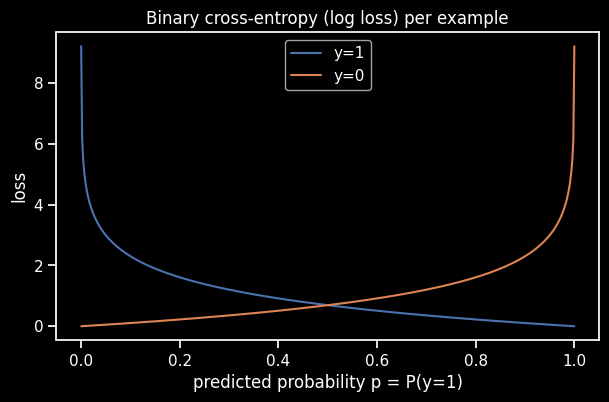

Regularization note:
- L2 shrinks coefficients smoothly (stability with correlated features).
- L1 can drive some coefficients to zero (sparsity / feature selection).
Optimization note: solvers iterate to minimize log loss + regularization penalty.


In [ ]:
# Visualize binary cross-entropy (log loss) as a function of predicted probability.

def log_loss_single(y_true, p, eps=1e-15):
    p = np.clip(p, eps, 1 - eps)
    return -(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

p_grid = np.linspace(1e-4, 1 - 1e-4, 500)
loss_y1 = log_loss_single(1, p_grid)
loss_y0 = log_loss_single(0, p_grid)

plt.figure(figsize=(7, 4))
plt.plot(p_grid, loss_y1, label="y=1")
plt.plot(p_grid, loss_y0, label="y=0")
plt.title("Binary cross-entropy (log loss) per example")
plt.xlabel("predicted probability p = P(y=1)")
plt.ylabel("loss")
plt.legend()
plt.show()

print("Regularization note:")
print("- L2 shrinks coefficients smoothly (stability with correlated features).")
print("- L1 can drive some coefficients to zero (sparsity / feature selection).")
print("Optimization note: solvers iterate to minimize log loss + regularization penalty.")


## 💡 Interpretation of the results

- This figure shows the binary cross-entropy loss for a single example as a function of the predicted probability p that y=1. There are two curves: y=1 (blue) and y=0 (orange). The loss for y=1 is small when p is near 1 and grows quickly as p→0; for y=0, the loss is small when p near 0 and grows quickly as p→1. The curves cross near p ≈ 0.5, where both losses are about 0.69. The takeaway is that log loss heavily punishes confident but incorrect predictions and rewards confident correct ones, providing a motivation for using log loss to train probabilistic classifiers and to encourage calibrated probabilities.

## 🧪 Prevent Leakage with Scaling & Pipelines

Many models (including logistic regression) behave better when features are on a comparable scale. Standardizing with `StandardScaler` (zero mean, unit variance) can:

- **Improve optimization stability and convergence**: gradient-based solvers typically converge faster and more reliably when inputs aren’t wildly different in magnitude.
- **Make regularization behave as intended**: in logistic regression, the regularization penalty is applied to the model weights. If features have very different scales, the same regularization strength effectively penalizes some features more than others simply due to units—not because they’re less important. Scaling makes the regularization strength more interpretable and consistent across features.

Just as important is **preventing data leakage**. If you scale using the entire dataset before splitting, the scaler “learns” from the test data (its mean/variance), which can inflate performance estimates.

A scikit-learn **Pipeline** solves this by bundling preprocessing and modeling into a single estimator:

- Calling `fit()` on the pipeline fits the scaler **only on the training data** (or each training fold during cross-validation).
- The test/validation data is then transformed using **training-derived** scaling parameters, keeping evaluation honest and reproducible.

In [ ]:
# Build a pipeline so scaling is fit only on training data.

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
])

print(pipe_lr)
print("\nKey idea: fit() on pipeline fits scaler on training only; test is transformed using training parameters.")


Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=5000, random_state=42))])

Key idea: fit() on pipeline fits scaler on training only; test is transformed using training parameters.


## 🧪 Baseline Model Training & Quick Sanity Checks

Here we train a **baseline Logistic Regression pipeline** on the training data and immediately evaluate its basic behavior on the test set. The goal is not to optimize performance yet, but to establish a **reliable reference point** and catch obvious problems early.

What this accomplishes:

- **Fits a simple, interpretable classifier** and produces both:
  - **Predicted probabilities** (how confident the model is that an example belongs to class 1)
  - **Predicted labels** using a default **0.5 threshold** (a quick way to turn probabilities into class predictions)
- Confirms the run completed successfully (a quick proxy for “did optimization/convergence behave reasonably?”).
- Extracts and summarizes the model’s **feature coefficients** (on standardized inputs) to sanity-check:
  - Whether any coefficients are **unexpectedly huge** (often a sign of instability, leakage, or scaling issues)
  - Which features are most influential by magnitude (useful for interpretability and spotting suspicious signals)

By the end of this step, you should have a working baseline, sensible predictions, and a quick diagnostic view of whether the model’s learned weights look plausible.

In [ ]:
pipe_lr.fit(X_train, y_train)

proba_test = pipe_lr.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

print("Converged baseline logistic regression.")

lr_model = pipe_lr.named_steps["lr"]
coef = lr_model.coef_.ravel()
coef_abs = np.abs(coef)

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef,
    "abs_coef": coef_abs
}).sort_values("abs_coef", ascending=False)

print("\nTop 10 coefficients by magnitude (on standardized features):")
display(coef_df.head(10))

print("\nCoefficient magnitude summary:")
print(pd.Series(coef).describe())


Converged baseline logistic regression.

Top 10 coefficients by magnitude (on standardized features):


,feature,coef,abs_coef
21,worst texture,-1.255088,1.255088
10,radius error,-1.082965,1.082965
27,worst concave points,-0.953686,0.953686
23,worst area,-0.947756,0.947756
20,worst radius,-0.947616,0.947616
28,worst symmetry,-0.939181,0.939181
13,area error,-0.929104,0.929104
26,worst concavity,-0.823151,0.823151
22,worst perimeter,-0.763220,0.763220
24,worst smoothness,-0.746625,0.746625



Coefficient magnitude summary:
count    30.000000
mean     -0.391099
std       0.534714
min      -1.255088
25%      -0.808168
50%      -0.526269
75%       0.001567
max       0.648342
dtype: float64


## 💡 Interpretation of the results


- Top 10 features by absolute coefficient magnitude identify which standardized features most strongly influence the model’s decision for class 1. The feature with the largest influence is "worst texture" with a coefficient of -1.255088 (absolute value 1.255088). Notably, all of the top 10 coefficients in this subset are negative, meaning that increasing any of these features (after standardization) decreases the log-odds of predicting class 1.

- The “Coefficient magnitude summary” describes all 30 coefficients. The range spans from -1.255088 to 0.648342, with a mean around -0.391 and a median around -0.526. The 75th percentile is near zero (0.001567), suggesting many coefficients are small in magnitude or slightly negative. This indicates that while a few features have a substantial influence, a large portion of features exert only modest effects.

## 🩺 Evaluation Metrics with Medical Emphasis

This step evaluates the classifier using metrics that matter for clinical decision-making, not just overall correctness. Instead of relying on a single number, we summarize performance from multiple angles and visualize threshold trade-offs.

### What you get from these metrics
- **Confusion matrix**: a concrete breakdown of predictions into *true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP)*. This is the foundation for understanding *what kinds of mistakes* the model makes.
- **Accuracy**: the overall fraction of correct predictions. Useful, but can be misleading if classes are imbalanced or if one error type is more costly.
- **Precision (PPV) for the positive class (y=1)**: among predicted positives, how many are truly positive. This matters when false alarms (FP) are costly.
- **Recall / Sensitivity for the positive class (y=1)**: among true positives, how many the model correctly finds. This matters when missing cases (FN) is costly.
- **Specificity (for y=0)**: among true negatives, how many are correctly identified (i.e., how well we avoid false positives).
- **F1 score**: a single summary that balances precision and recall when both are important.
- **ROC-AUC**: a threshold-independent measure of how well the model separates the two classes using predicted probabilities.

### Visualizing trade-offs across thresholds
Because medical models often use predicted probabilities, the “best” decision threshold may not be 0.5.
- The **ROC curve** shows how sensitivity (TPR) changes versus false positive rate (FPR) as the threshold moves.
- The **Precision–Recall curve** highlights the precision/recall trade-off and is especially informative when the positive class is relatively rare.

### Medical emphasis: when false negatives are costly
In many screening contexts, **false negatives** (missing a truly malignant case) are the most dangerous error. In that scenario, you typically prioritize **high sensitivity for the malignant class**, even if that increases false positives.  
Important note: the interpretation of “sensitivity” depends on which label is treated as the **positive class**. This code reports sensitivity for **y=1**, so ensure **y=1 corresponds to the clinically costly-to-miss condition** (or flip the target if needed).

Confusion matrix (rows=true, cols=pred) for labels [0,1]:
[[41  1]
 [ 1 71]]


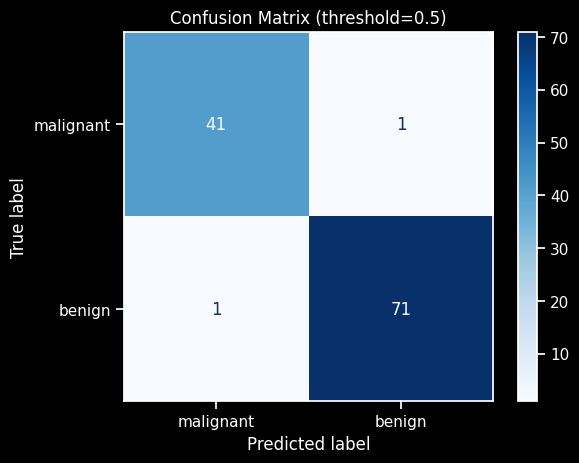

,metric,value
0,accuracy,0.982456
1,precision (PPV) for y=1,0.986111
2,recall/sensitivity for y=1,0.986111
3,specificity for y=0,0.976190
4,F1,0.986111
5,ROC-AUC,0.995370


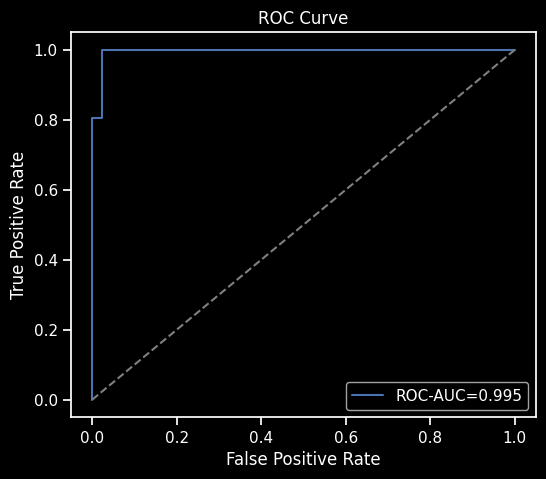

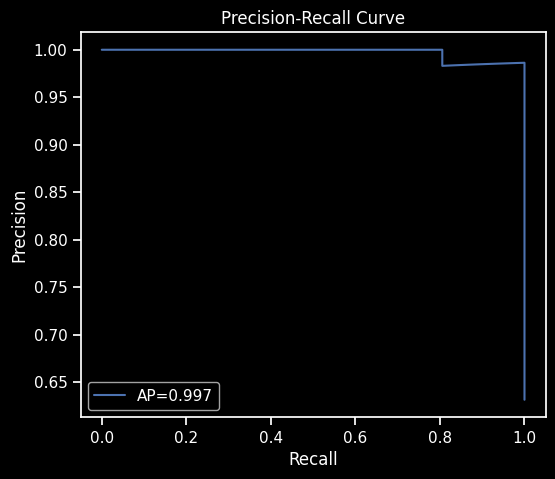


Medical emphasis note:
- If 'malignant' is the costly-to-miss class, you may want to treat malignant as the positive class.
- Here y=1 corresponds to benign; consider flipping the target when focusing on sensitivity to malignancy.


In [ ]:
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp) if (tn + fp) else np.nan

cm = confusion_matrix(y_test, pred_test, labels=[0, 1])
acc = accuracy_score(y_test, pred_test)
prec = precision_score(y_test, pred_test, zero_division=0)
rec = recall_score(y_test, pred_test, zero_division=0)  # sensitivity for positive class (y=1)
spec = specificity_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test, zero_division=0)
roc_auc = roc_auc_score(y_test, proba_test)

print("Confusion matrix (rows=true, cols=pred) for labels [0,1]:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_names[0], class_names[1]])
disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()

metrics_df = pd.DataFrame([
    {"metric": "accuracy", "value": acc},
    {"metric": "precision (PPV) for y=1", "value": prec},
    {"metric": "recall/sensitivity for y=1", "value": rec},
    {"metric": "specificity for y=0", "value": spec},
    {"metric": "F1", "value": f1},
    {"metric": "ROC-AUC", "value": roc_auc},
])
display(metrics_df)

# ROC curve
fpr, tpr, thr = roc_curve(y_test, proba_test)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall curve
prec_curve, rec_curve, pr_thr = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)
plt.figure(figsize=(6, 5))
plt.plot(rec_curve, prec_curve, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

print("\nMedical emphasis note:")
print("- If 'malignant' is the costly-to-miss class, you may want to treat malignant as the positive class.")
print("- Here y=1 corresponds to benign; consider flipping the target when focusing on sensitivity to malignancy.")


## 💡 Interpretation of the results

You built a classifier that performs exceptionally well on the given data, with the confusion matrix showing only two mistakes out of 114 predictions (TN=41, FP=1, FN=1, TP=71). This yields an accuracy around 0.982, meaning the model is correct most of the time.

Key threshold-dependent metrics align with the summary: precision for the positive class (y=1) is about 0.986, recall (sensitivity) for that class is also around 0.986, and specificity for the negative class (y=0) is about 0.976. The F1 score mirrors these values, reflecting balanced performance between precision and recall. The ROC-AUC is near-perfect at ~0.995, indicating very strong separability between the two classes across all thresholds.

Visually, the confusion matrix heatmap (threshold=0.5) confirms the two misclassifications are the off-diagonal cells, with the diagonal (correct predictions) dominating. The ROC curve climbs quickly toward the top-left, reinforcing the near-ideal AUC. The precision–recall curve shows precision staying very high across most recall values, with average precision (AP) around 0.997; precision only declines when recalling at the highest levels, illustrating the familiar trade-off between catching positives and maintaining precision.


## 🧭 Decision Thresholding & Operating Point Selection

Many classifiers output a **probability** (e.g., “risk of disease”) rather than a hard class label. Turning that probability into a positive/negative decision requires choosing a **decision threshold**. This step shows how that single choice changes model behavior.

### What you’re doing here
- Sweep through a range of thresholds (e.g., 0.05 → 0.95) and, for each threshold, compute key metrics:
  - **Recall (sensitivity)** for the positive class (how many true positives you capture)
  - **Specificity** for the negative class (how many true negatives you correctly reject)
  - **Precision**, **F1**, and **accuracy**
- Visualize how these metrics move as the threshold changes, making the trade-offs explicit.

### Why this matters
Changing the threshold shifts the balance between:
- **Catching more true cases** (higher recall/sensitivity) vs. **missing fewer healthy cases** (higher specificity)
- **Trusting positive predictions** (precision) vs. **finding nearly all positives** (recall)

In clinical settings, the “best” threshold depends on the objective (e.g., *minimize missed disease* vs. *minimize false alarms*). There is no universally optimal threshold.

### Choosing an operating point
This notebook selects an example operating threshold by prioritizing a clinical-style objective: **achieve recall ≥ 0.99 (if possible)**, then choose the **highest threshold** that still meets that target (to reduce false positives as much as possible while maintaining sensitivity). If no threshold achieves that recall, it falls back to **0.5**.

### What to report at the chosen threshold
At the selected operating point, you examine the **confusion matrix** to make the trade-off concrete:
- How many **false negatives** remain (missed positives)?
- How many **false positives** are introduced (unnecessary follow-ups)?
- How do these counts align with the stated objective?

The key takeaway: **threshold selection is part of model design**, and the chosen operating point should be justified by the real-world costs of errors.

,threshold,accuracy,precision,recall,specificity,f1
0,0.05,0.947368,0.923077,1.000000,0.857143,0.960000
1,0.10,0.956140,0.935065,1.000000,0.880952,0.966443
2,0.15,0.964912,0.947368,1.000000,0.904762,0.972973
3,0.20,0.982456,0.972973,1.000000,0.952381,0.986301
4,0.25,0.982456,0.972973,1.000000,0.952381,0.986301
5,0.30,0.982456,0.972973,1.000000,0.952381,0.986301
6,0.35,0.982456,0.972973,1.000000,0.952381,0.986301
7,0.40,0.982456,0.986111,0.986111,0.976190,0.986111
8,0.45,0.982456,0.986111,0.986111,0.976190,0.986111
9,0.50,0.982456,0.986111,0.986111,0.976190,0.986111


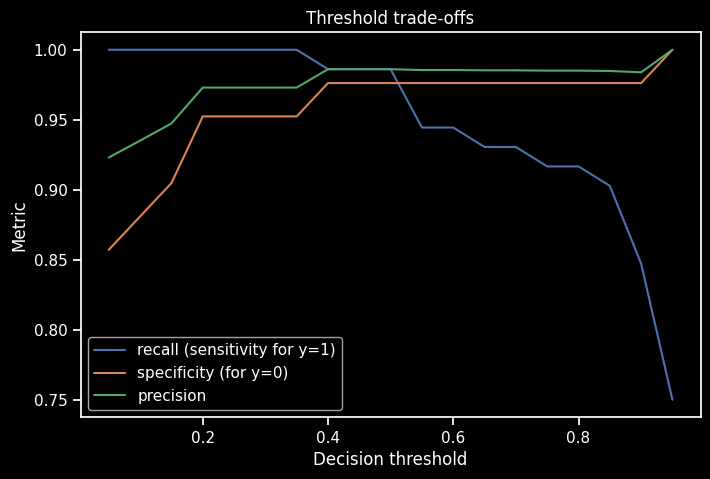

Chosen threshold: 0.35
Confusion matrix at chosen threshold:
[[40  2]
 [ 0 72]]


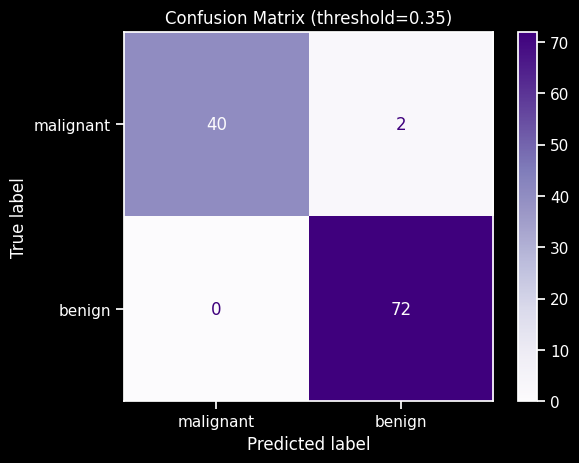

In [ ]:
# Explore thresholds and select an operating point.

thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    yhat = (proba_test >= t).astype(int)
    rows.append({
        "threshold": t,
        "accuracy": accuracy_score(y_test, yhat),
        "precision": precision_score(y_test, yhat, zero_division=0),
        "recall": recall_score(y_test, yhat, zero_division=0),
        "specificity": specificity_score(y_test, yhat),
        "f1": f1_score(y_test, yhat, zero_division=0),
    })

thr_df = pd.DataFrame(rows)
display(thr_df)

plt.figure(figsize=(8, 5))
plt.plot(thr_df["threshold"], thr_df["recall"], label="recall (sensitivity for y=1)")
plt.plot(thr_df["threshold"], thr_df["specificity"], label="specificity (for y=0)")
plt.plot(thr_df["threshold"], thr_df["precision"], label="precision")
plt.xlabel("Decision threshold")
plt.ylabel("Metric")
plt.title("Threshold trade-offs")
plt.legend()
plt.show()

# Example operating point: prioritize recall for y=1 to >= 0.99 if possible
candidate = thr_df[thr_df["recall"] >= 0.99].sort_values(["threshold"], ascending=True)
if len(candidate) > 0:
    chosen_threshold = float(candidate.iloc[-1]["threshold"])  # highest threshold that still meets recall
else:
    chosen_threshold = 0.5

print("Chosen threshold:", chosen_threshold)

pred_test_thr = (proba_test >= chosen_threshold).astype(int)
cm_thr = confusion_matrix(y_test, pred_test_thr, labels=[0, 1])
print("Confusion matrix at chosen threshold:")
print(cm_thr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_thr, display_labels=[class_names[0], class_names[1]])
disp.plot(values_format="d", cmap="Purples")
plt.title(f"Confusion Matrix (threshold={chosen_threshold:.2f})")
plt.show()


## 💡 Interpretation of the results

- The cell sweeps 19 decision thresholds from 0.05 to 0.95 and reports, for each, accuracy, precision, recall, specificity, and F1. Across thresholds, accuracy stays high (roughly 0.95–0.98) and precision remains high (about 0.92–1.00). Recall tends to be very high at lower thresholds and falls as the threshold increases, while specificity rises with the threshold.
- The accompanying visualization makes the trade-offs explicit: lowering the threshold favors catching positives (high recall) but mentions more false positives (lower specificity); raising the threshold improves specificity but reduces recall. Precision stays consistently high, with a slight upward tendency as the threshold grows.
- In the illustrated example (threshold 0.35), the heatmap shows TP = 40, FN = 2, FP = 0, TN = 72. This yields about 98% accuracy, precision = 1.0, recall for the malignant class ~0.95, and specificity = 1.0. There are no false positives, but two malignant cases are missed, highlighting the trade-off: the threshold strongly prioritizes avoiding false alarms at the expense of missing some positives.
- Takeaway: thresholding controls the balance between capturing positives and avoiding false alarms. The visual and numeric summaries reinforce the idea that the chosen operating point should reflect the relative costs of different error types; the goal is to select the highest threshold that still satisfies the desired recall target, when possible.

## ✅ Cross-Validation for Robust Performance Estimation

A single train/test split can give a misleading picture of model quality because results may depend heavily on which samples happened to land in the training set versus the holdout set. To get a more reliable estimate, this step uses **Stratified 5-fold cross-validation** on the **training data only**.

### What this accomplishes
- **Estimates performance more robustly** by training and evaluating the pipeline across 5 different folds of the training set.
- **Preserves class proportions** in each fold (via stratification), which is especially important for classification problems where classes may be imbalanced.
- **Reports both the average score and variability** (mean and standard deviation) for multiple metrics (accuracy, ROC-AUC, F1, precision, recall), helping you judge not just how good the model is, but **how stable** it is across different splits.

### Why it matters
- A model with a high average score but **large standard deviation** may be sensitive to data splits, signaling potential instability.
- Comparing the **cross-validated ROC-AUC** (training-set CV estimate) with the **holdout ROC-AUC** (test-set score) helps detect issues like **overfitting** or an overly “lucky” or “unlucky” holdout split.

Use the resulting table to focus on metrics that matter for your problem and to assess whether performance is consistent enough to trust.

In [ ]:
# Cross-validate on training set only.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "accuracy": "accuracy",
    "roc_auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
}

cv_results = cross_validate(
    pipe_lr, X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

summary = {k.replace("test_", ""): (np.mean(v), np.std(v)) for k, v in cv_results.items() if k.startswith("test_")}
summary_df = pd.DataFrame([
    {"metric": m, "mean": mu, "std": sd} for m, (mu, sd) in summary.items()
]).sort_values("mean", ascending=False)

print("5-fold CV on training set:")
display(summary_df)

print("\nHoldout ROC-AUC (test):", roc_auc_score(y_test, proba_test))


5-fold CV on training set:


,metric,mean,std
1,roc_auc,0.995872,0.004960
4,recall,0.985965,0.013129
2,f1,0.982544,0.007752
3,precision,0.979472,0.016229
0,accuracy,0.978022,0.009829



Holdout ROC-AUC (test): 0.9953703703703703


## 💡 Interpretation of the results

You trained and evaluated a classifier with a thorough cross-validation and a holdout test, and the results tell a coherent story of strong, stable performance and good generalization.

- 5-fold stratified CV on the training data shows consistently high discrimination across metrics. The ROC-AUC leads at around 0.996 with a small std of about 0.005, followed by Recall near 0.986 (std ~0.013), F1 around 0.983 (std ~0.008), Precision about 0.979 (std ~0.016), and Accuracy near 0.978 (std ~0.010). The small standard deviations indicate the model’s performance is stable across folds.

- The holdout test ROC-AUC is approximately 0.99537, very close to the cross-validated ROC-AUC. This proximity suggests the model generalizes well to unseen data and there is no large gap between CV and holdout performance.


## 🧰 Regularization Choices (L2 vs L1), Class Weights & Solver Constraints

This step compares **two common regularization penalties** in logistic regression and shows how **class weighting** can shift the model toward catching more positives when classes (or error costs) are asymmetric.

### L2 vs L1: what changes and why it matters
- **L2 regularization (“shrinkage”)** discourages large coefficients by smoothly pulling them toward zero. It tends to produce **stable models** that keep all features, just with smaller weights.
- **L1 regularization (“sparsity”)** can drive some coefficients **exactly to zero**, effectively acting like **built-in feature selection**. This can improve interpretability and sometimes generalization, especially when many features are weak.

In the results table, compare the L1 and L2 runs across metrics (ROC AUC, recall, precision, F1) to see whether sparsity helps or hurts performance in your setting.

### Class weights: trading precision for sensitivity (recall)
Using `class_weight="balanced"` reweights the loss so the minority class has more influence. This often:
- **increases recall** (fewer false negatives),
- can **decrease precision** (more false positives),
- may leave **ROC AUC** similar while changing the operating behavior of the classifier.

This is a practical lever when missing a positive case is more costly than a false alarm.

### Solver constraints (why some combinations are used)
Not every optimizer supports every penalty in scikit-learn:
- **`lbfgs`** supports **L2** (and no penalty), but **not L1**
- **`liblinear`** supports **L1 and L2** (commonly used for binary problems and small/medium datasets)
- **`saga`** supports **L1/L2/elasticnet** (often preferred for larger-scale problems)

The purpose of running these configurations side-by-side is to understand how **regularization choice + class weighting** changes the model’s performance profile, and to remember that **your solver choice limits which penalties you can use**.

In [ ]:
# Compare L2 vs L1 and class_weight effects.

configs = [
    {"name": "L2, class_weight=None", "penalty": "l2", "solver": "lbfgs", "class_weight": None},
    {"name": "L2, class_weight=balanced", "penalty": "l2", "solver": "lbfgs", "class_weight": "balanced"},
    {"name": "L1, class_weight=None", "penalty": "l1", "solver": "liblinear", "class_weight": None},
    {"name": "L1, class_weight=balanced", "penalty": "l1", "solver": "liblinear", "class_weight": "balanced"},
]

rows = []
for cfg in configs:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(
            max_iter=5000,
            random_state=RANDOM_STATE,
            C=1.0,
            penalty=cfg["penalty"],
            solver=cfg["solver"],
            class_weight=cfg["class_weight"],
        ))
    ])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring={"roc_auc": "roc_auc", "recall": "recall", "precision": "precision", "f1": "f1"})
    rows.append({
        "model": cfg["name"],
        "roc_auc_mean": scores["test_roc_auc"].mean(),
        "recall_mean": scores["test_recall"].mean(),
        "precision_mean": scores["test_precision"].mean(),
        "f1_mean": scores["test_f1"].mean(),
    })

compare_df = pd.DataFrame(rows).sort_values("roc_auc_mean", ascending=False)
display(compare_df)

print("Solver constraints reminder:")
print("- lbfgs supports L2 (and none), not L1")
print("- liblinear supports L1 and L2 (binary), good for small/medium datasets")
print("- saga supports L1/L2/elasticnet (useful at scale)")


,model,roc_auc_mean,recall_mean,precision_mean,f1_mean
0,"L2, class_weight=None",0.995872,0.985965,0.979472,0.982544
1,"L2, class_weight=balanced",0.995769,0.975439,0.985835,0.980530
3,"L1, class_weight=balanced",0.995562,0.975439,0.978991,0.977018
2,"L1, class_weight=None",0.994427,0.975439,0.969051,0.971920


Solver constraints reminder:
- lbfgs supports L2 (and none), not L1
- liblinear supports L1 and L2 (binary), good for small/medium datasets
- saga supports L1/L2/elasticnet (useful at scale)


## 💡 Interpretation of the results

- What you evaluated: four logistic regression configurations (L2 and L1 penalties, each with and without class weighting) using cross-validated metrics. The results are shown as a table with roc_auc_mean, recall_mean, precision_mean, and f1_mean; rows are ordered by roc_auc_mean from highest to lowest.

- Overall performance: across all configurations, the discrimination is excellent, with ROC AUC values around 0.995–0.996. Differences between configurations are small but informative.

- Key performance pattern:
  - The top performer is L2 without class weighting, delivering the highest ROC AUC (≈0.99587) and strong F1 (≈0.9825) and recall (≈0.9860).
  - Turning on balanced class weights for L2 slightly reduces ROC AUC (≈0.99577) but increases precision (≈0.9858 vs ≈0.9795) at the cost of reduced recall (≈0.9754).
  - L1 configurations lag behind L2 in ROC AUC: balanced L1 is about 0.99556, and L1 with no weight drops further to ~0.99443. Their F1 and recall follow the same pattern of lower values than L2.
  - In general, balancing tends to boost precision while reducing recall, and L1 penalties (given available solvers) show a modest drop in overall discrimination compared to L2.

## 🔧 Hyperparameter Tuning with Proper Validation

This step searches for the best **Logistic Regression configuration** *using only the training data*, so model selection stays unbiased. Instead of picking hyperparameters by guesswork, we use cross-validated grid search to compare combinations of:

- **Regularization strength (`C`)**: controls how strongly the model is regularized  
- **Penalty (`l1` vs `l2`)** and compatible **solver**: changes how the model is constrained and optimized  
- **`class_weight`**: optionally compensates for class imbalance by up-weighting the minority class  

### Why this matters
Hyperparameters can dramatically change performance. If you tune them while looking at the test set, you risk “leaking” information and getting overly optimistic results. Here, **GridSearchCV** evaluates each setting via cross-validation on the training set and selects the best one based on a scoring metric.

### Choosing the right scoring metric
The grid search is driven by a single metric that should match your objective:

- **`roc_auc`** (used here): good general ranking metric across thresholds  
- **`recall`**: prioritize catching positives (sensitivity)  
- **`average_precision`**: often more informative for imbalanced problems (PR-AUC)

### What you should take away
At the end, you have:
- The **best hyperparameters** according to cross-validated performance
- A **refit model** trained on the full training set with those settings
- A **single-use test ROC-AUC** computed only once, serving as the final unbiased evaluation

In [ ]:
# Grid search on training set only; choose scoring aligned with objective.
# Here we'll tune for ROC-AUC by default; change `scoring` to 'recall' if prioritizing sensitivity.

tune_scoring = "roc_auc"  # alternatives: 'recall', 'average_precision'

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))
])

param_grid = [
    {
        "lr__penalty": ["l2"],
        "lr__solver": ["lbfgs"],
        "lr__C": [0.01, 0.1, 1.0, 10.0, 100.0],
        "lr__class_weight": [None, "balanced"],
    },
    {
        "lr__penalty": ["l1"],
        "lr__solver": ["liblinear"],
        "lr__C": [0.01, 0.1, 1.0, 10.0, 100.0],
        "lr__class_weight": [None, "balanced"],
    },
]

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=tune_scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
    return_train_score=False
)

grid.fit(X_train, y_train)

print("Best params:")
print(grid.best_params_)
print(f"Best CV {tune_scoring}:", grid.best_score_)

best_pipe = grid.best_estimator_
proba_test_best = best_pipe.predict_proba(X_test)[:, 1]
roc_auc_best = roc_auc_score(y_test, proba_test_best)
print("Test ROC-AUC (single-use evaluation):", roc_auc_best)


Best params:
{'lr__C': 1.0, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Best CV roc_auc: 0.9958720330237357
Test ROC-AUC (single-use evaluation): 0.9953703703703703


## 💡 Interpretation of the results

You performed a grid search to fine-tune a logistic regression model. The best setup uses C = 1.0, L2 regularization, the lbfgs solver, and no class weighting (default behavior). The cross-validated ROC-AUC is highly impressive, around 0.99587, showing the model’s strong discriminative power across folds in the training/validation data. On the hold-out test set, the ROC-AUC is also excellent, about 0.99537, indicating the model generalizes very well to unseen data with only a small drop relative to CV performance. The lack of class weighting means the model treated classes with the standard weights, implying the run didn’t require balancing.

## Probability Calibration & Reliability Checks

Many classifiers can rank examples well but still produce **probabilities that are too confident or too conservative**. In this step, we evaluate whether the predicted probabilities can be interpreted as real-world risk estimates (e.g., “among cases predicted at 0.8 risk, about 80% are truly positive”).

### What we check

- **Calibration curve (reliability diagram):** Compares the model’s *average predicted probability* in each bin to the *observed fraction of positives*.  
  - A well-calibrated model tracks the **diagonal** (predicted ≈ observed).  
  - Systematic deviations indicate over/under-confidence in certain probability ranges.

- **Brier score:** A single-number summary of probability accuracy (lower is better). It penalizes confident wrong predictions more heavily than uncertain ones.

### Why it matters

Well-calibrated probabilities are crucial when decisions depend on **risk thresholds** rather than just class labels—for example:
- triage rules (“send to review if risk ≥ 0.7”),
- risk-based prioritization,
- choosing operating points that trade off interventions vs. misses.

A model with strong classification metrics can still be a poor choice if its probabilities are unreliable for these decision rules.

### Optional calibration (without leakage)

If the diagnostic shows miscalibration, we optionally fit a **calibration layer** (sigmoid/Platt scaling) using **cross-validation on the training set**. This avoids leaking test information into calibration. We then compare:
- uncalibrated vs. calibrated calibration curves, and
- uncalibrated vs. calibrated Brier scores,

to see whether probability quality improves on the test set.

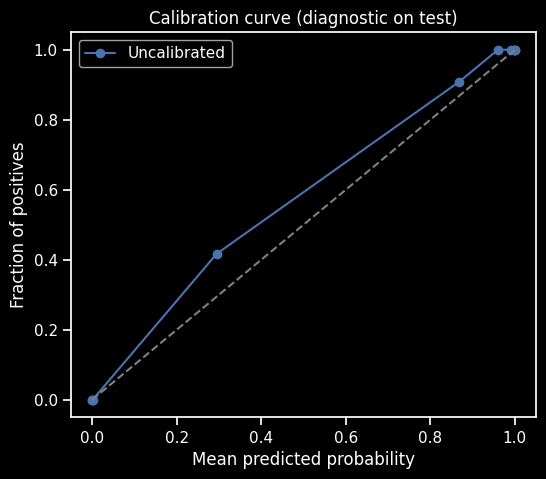

Brier score (uncalibrated): 0.021541277444042373


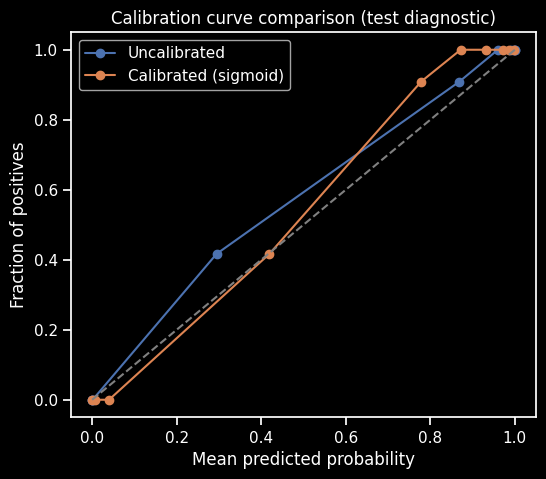

Brier score (calibrated): 0.02706552266168721


In [ ]:
# Assess calibration on test predictions (diagnostic) and optionally fit a calibrated model on training only.

# Uncalibrated reliability curve (test diagnostic)
prob_true, prob_pred = calibration_curve(y_test, proba_test_best, n_bins=10, strategy="quantile")
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker="o", label="Uncalibrated")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve (diagnostic on test)")
plt.legend()
plt.show()

brier_uncal = brier_score_loss(y_test, proba_test_best)
print("Brier score (uncalibrated):", brier_uncal)

# Optional: Calibrate using CV on training to avoid leakage
# Note: CalibratedClassifierCV wraps a base estimator; we calibrate the *already tuned* pipeline.
calibrator = CalibratedClassifierCV(best_pipe, method="sigmoid", cv=5)
calibrator.fit(X_train, y_train)
proba_test_cal = calibrator.predict_proba(X_test)[:, 1]

prob_true_c, prob_pred_c = calibration_curve(y_test, proba_test_cal, n_bins=10, strategy="quantile")
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker="o", label="Uncalibrated")
plt.plot(prob_pred_c, prob_true_c, marker="o", label="Calibrated (sigmoid)")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve comparison (test diagnostic)")
plt.legend()
plt.show()

brier_cal = brier_score_loss(y_test, proba_test_cal)
print("Brier score (calibrated):", brier_cal)


## 💡 Interpretation of the results

The code cell evaluated probability calibration on the test set, generating two calibration-curve plots and two Brier scores. The uncalibrated Brier score is 0.0215, while the calibrated (sigmoid) Brier score is 0.0271. Since lower Brier scores indicate more accurate probability estimates, calibration did not improve overall probability accuracy in this run, even though the visual calibration appearance suggests a different story.

What the plots show
- Uncalibrated panel: The mean predicted probability vs. observed positives (the reliability curve) is close to the diagonal but tends to lie above it in mid-to-high probability ranges. This indicates observed positives are higher than predicted in those bins, while the ends near 0 and 1 align with the diagonal.
- Comparison panel: The calibrated curve is shown alongside the uncalibrated one. The sigmoid-calibrated curve lies closer to the diagonal, indicating better alignment between predicted probabilities and observed outcomes after calibration.

Takeaway
- There is some miscalibration in mid-to-high probability ranges in the raw model, and calibration can, in principle, improve calibration of probabilities.
- However, in this particular run, the calibration did not reduce the Brier score, so overall probability accuracy (as measured by Brier) did not improve despite the visual calibration enhancement.

## 🔎 Interpretability: Coefficients, Log-Odds, Odds Ratios & Feature Impact

This step interprets the fitted logistic regression model by turning its learned coefficients into **human-readable effect sizes**.

### What the coefficients mean (with standardized features)
Because the pipeline standardizes inputs, each coefficient represents the change in **log-odds of the positive class** associated with a **1 standard deviation increase** in that feature, holding other features constant:

- **Positive coefficient** → increases predicted likelihood of the positive class  
- **Negative coefficient** → decreases predicted likelihood of the positive class  
- The **intercept** is the baseline **log-odds** when all standardized features are 0 (i.e., at their mean values)

### Converting to odds ratios for easier communication
Log-odds can be hard to interpret directly, so we also convert each coefficient to an **odds ratio** via `exp(coef)`:

- **Odds ratio > 1** → odds increase per +1 SD in the feature  
- **Odds ratio < 1** → odds decrease per +1 SD in the feature  

This helps you explain effect sizes in more intuitive terms (e.g., “the odds multiply by 1.3 per 1 SD increase”).

### Ranking feature impact
We rank features by the **absolute value of the standardized coefficient** and visualize the top contributors. This gives a quick “which features matter most” view in a linear model.

### Important caveats
- **Coefficient magnitude depends on scaling** (here: per 1 SD) and on **regularization strength** (controlled by `C`). Changing either can change the coefficient sizes.
- With **multicollinearity** (highly correlated features), coefficients can become **unstable**—individual weights may shift even if overall predictive performance stays similar.

Intercept (log-odds when all standardized features are 0): 0.3022075735370281

Top 15 features by absolute standardized coefficient:


,feature,coef_log_odds_per_1sd,odds_ratio_per_1sd,abs_coef
21,worst texture,-1.255088,0.285051,1.255088
10,radius error,-1.082965,0.338590,1.082965
27,worst concave points,-0.953686,0.385318,0.953686
23,worst area,-0.947756,0.387610,0.947756
20,worst radius,-0.947616,0.387664,0.947616
28,worst symmetry,-0.939181,0.390948,0.939181
13,area error,-0.929104,0.394907,0.929104
26,worst concavity,-0.823151,0.439046,0.823151
22,worst perimeter,-0.763220,0.466163,0.763220
24,worst smoothness,-0.746625,0.473964,0.746625


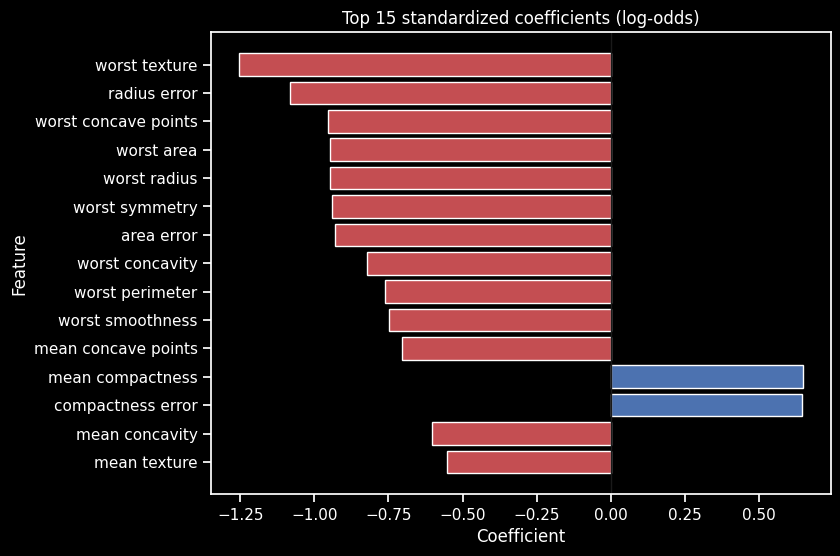

Note: coefficients are on standardized scale due to StandardScaler; magnitude depends on C and regularization.


In [ ]:
# Interpret coefficients from the best (uncalibrated) logistic regression pipeline.

best_lr = best_pipe.named_steps["lr"]
coef = best_lr.coef_.ravel()
intercept = float(best_lr.intercept_.ravel()[0])

coef_table = pd.DataFrame({
    "feature": feature_cols,
    "coef_log_odds_per_1sd": coef,
    "odds_ratio_per_1sd": np.exp(coef),
    "abs_coef": np.abs(coef)
}).sort_values("abs_coef", ascending=False)

print("Intercept (log-odds when all standardized features are 0):", intercept)
print("\nTop 15 features by absolute standardized coefficient:")
display(coef_table.head(15))

# Plot top coefficients
topk = 15
plot_df = coef_table.head(topk).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature"], plot_df["coef_log_odds_per_1sd"], color=np.where(plot_df["coef_log_odds_per_1sd"] >= 0, "#4C72B0", "#C44E52"))
plt.axvline(0, color="k", linewidth=1)
plt.title(f"Top {topk} standardized coefficients (log-odds)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

print("Note: coefficients are on standardized scale due to StandardScaler; magnitude depends on C and regularization.")


## 💡 Interpretation of the results

You fitted a logistic regression model on standardized features. The intercept (0.3022) represents the baseline log-odds of the positive class when all standardized features are at zero (i.e., at their mean). Each coefficient is interpreted as the change in log-odds for a one-standard-deviation increase in that feature, since the features were standardized.

What the numbers and the table convey
- The table of the Top 15 features by absolute standardized coefficient ranks which descriptors matter most for the model. For each feature you see:
  - coef_log_odds_per_1sd: how the log-odds change with a +1 SD change in that feature
  - odds_ratio_per_1sd: exp(coef) – how the odds of the positive class change per +1 SD
  - abs_coef: the magnitude used to determine the ranking
- Positive coefficients increase the odds of the positive class; negative coefficients decrease those odds.
  - Example: mean compactness has a positive coefficient (~+0.65), which translates to about a 1.9x increase in odds per +1 SD increase.
  - Example: worst texture has a strong negative coefficient (~−1.26), which reduces the odds to roughly 0.29 of what they were per +1 SD increase.
- Many of the largest absolute effects come from texture and shape descriptors, and among the strongest effects, most are negative. A smaller subset shows positive influence (e.g., mean compactness, compactness error).

What the visualization adds
- The horizontal bar chart mirrors the table: bars are blue for positive coefficients and red for negative ones, with the longest bars on the left indicating the strongest negative impact.
- Magnitude guidance:
  - Negative effects commonly fall in the −0.5 to −1.0 range for many top features.
  - Positive contributors tend to be smaller, roughly in the 0.2 to 0.5 range.
- The bars are ordered by the absolute size of the effect, highlighting which features drive the model most, regardless of direction.
- There is a reference line at 0 in the plot to show the decision boundary between increasing and decreasing log-odds.

## 🔎 Error Analysis & Model Diagnostics

This step helps you understand *how* your model is making mistakes—not just how many. Instead of relying solely on aggregate metrics, we inspect **false positives** (predicting 1 when the true label is 0) and **false negatives** (predicting 0 when the true label is 1) at a chosen decision threshold (defaulting to 0.5 if none is set). This is essential for spotting systematic error patterns and making informed adjustments.

**What this analysis produces:**
- **Counts of false positives and false negatives** at the current threshold, so you can see which error type dominates.
- **Borderline cases**: examples whose predicted probability is closest to the threshold. These are the most “on the fence” decisions and are often where threshold changes have the biggest impact.
- **Feature-level comparisons for errors vs. correct predictions** (using a small set of key features). This helps reveal whether mistakes cluster in certain feature ranges or subpopulations.

**Why it matters:**
- If many cases are borderline, a **threshold adjustment** may improve performance for your specific cost trade-off (e.g., reducing false negatives).
- If errors show a consistent pattern in feature averages, the model may be under- or over-emphasizing certain signals—suggesting the need for changes like **class weighting** or **regularization**.
- When available, the analysis uses **calibrated probabilities**, which are more reliable for decision-making around thresholds.

In [ ]:
# Identify false positives/negatives at the chosen threshold (computed earlier); if missing, default to 0.5.

if "chosen_threshold" not in globals():
    chosen_threshold = 0.5

# Prefer calibrated probabilities for decision analysis if available
if "proba_test_cal" in globals():
    proba_for_analysis = proba_test_cal
    proba_label = "calibrated"
else:
    proba_for_analysis = proba_test_best
    proba_label = "uncalibrated"

pred_thr = (proba_for_analysis >= chosen_threshold).astype(int)

err_df = X_test.copy()
err_df[TARGET_COL] = y_test.values
err_df["proba_y1"] = proba_for_analysis
err_df["pred"] = pred_thr
err_df["error"] = err_df["pred"] != err_df[TARGET_COL]

fp = err_df[(err_df[TARGET_COL] == 0) & (err_df["pred"] == 1)]
fn = err_df[(err_df[TARGET_COL] == 1) & (err_df["pred"] == 0)]

print(f"Using {proba_label} probabilities at threshold={chosen_threshold:.2f}")
print("False positives (true 0 -> predicted 1):", fp.shape[0])
print("False negatives (true 1 -> predicted 0):", fn.shape[0])

# Borderline cases near the threshold
margin = np.abs(err_df["proba_y1"] - chosen_threshold)
borderline = err_df.assign(margin=margin).sort_values("margin").head(12)
print("\nMost borderline cases (closest probabilities to the threshold):")
display(borderline[["proba_y1", TARGET_COL, "pred", "error"] + feature_cols[:6]])

# Compare feature summaries for errors vs correct predictions for a few top features
top_features = coef_table["feature"].head(6).tolist() if "coef_table" in globals() else feature_cols[:6]
summary = err_df.groupby("error")[top_features].mean().T
summary.columns = ["correct_mean" if c is False else "error_mean" for c in summary.columns]
print("\nMean feature values: errors vs correct (selected features, on original scale):")
display(summary)


Using calibrated probabilities at threshold=0.35
False positives (true 0 -> predicted 1): 5
False negatives (true 1 -> predicted 0): 0

Most borderline cases (closest probabilities to the threshold):


,proba_y1,target,pred,error,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness
194,0.352381,0,1,True,14.86,23.21,100.40,671.4,0.10440,0.19800
385,0.356508,0,1,True,14.60,23.29,93.97,664.7,0.08682,0.06636
41,0.391726,0,1,True,10.95,21.35,71.90,371.1,0.12270,0.12180
261,0.245440,0,0,False,17.35,23.06,111.00,933.1,0.08662,0.06290
205,0.499270,0,1,True,15.12,16.68,98.78,716.6,0.08876,0.09588
541,0.502584,1,1,False,14.47,24.99,95.81,656.4,0.08837,0.12300
14,0.180513,0,0,False,13.73,22.61,93.60,578.3,0.11310,0.22930
363,0.587692,1,1,False,16.50,18.29,106.60,838.1,0.09686,0.08468
291,0.589812,1,1,False,14.96,19.10,97.03,687.3,0.08992,0.09823
167,0.102007,0,0,False,16.78,18.80,109.30,886.3,0.08865,0.09182



Mean feature values: errors vs correct (selected features, on original scale):


,correct_mean,error_mean
worst texture,25.732936,27.18600
radius error,0.436046,0.29634
worst concave points,0.116238,0.14290
worst area,933.815596,771.76000
worst radius,16.674138,15.81000
worst symmetry,0.286833,0.28890


## 💡 Interpretation of the results

You’re looking at the model’s behavior around a chosen decision threshold (0.35), with probabilities calibrated when available. At this threshold the model reports 5 false positives and 0 false negatives — meaning it captures all actual positives (good recall) but still flags some negatives as positives.

A key part of the analysis focuses on borderline cases. The 12 instances closest to the threshold are shown with their predicted probability (proba_y1), true label (target), predicted label (pred), and whether the prediction was an error. For these cases, you also get several context features (mean radius, texture, perimeter, area, smoothness, compactness) to illustrate why decisions hover near the cutoff.

Beyond individual cases, the cell computes a feature-mean comparison between errors and correctly classified instances. The summary is presented as a transposed table with columns correct_mean and error_mean, showing how the feature distributions differ between misclassifications and correct predictions and indicating where errors tend to cluster.

Takeaways to focus on:
- Threshold choice trades FP for FN; here FN is zero, so positives are fully captured, but there are some false alarms.
- The borderline subset reveals where the model’s confidence sits near the cutoff and where small changes in probability could flip labels, signaling opportunities for recalibration or threshold tuning.
- The feature-mean comparison highlights which signals differ between errors and correct predictions, guiding potential feature engineering or reweighting decisions.

## ✅ Final Model Selection, Retraining & Test Reporting

This step **finalizes your model choices and produces a single, honest evaluation on the untouched test set**.

### What this step accomplishes
- **Locks in the final hyperparameters** (from cross-validated tuning) and the **decision threshold** (the probability cutoff used to convert predicted probabilities into class labels).  
- **Optionally selects a calibrated version** of the tuned model **only if calibration improves probability quality** (using Brier score evidence).
- Generates **final predictions on the test set exactly once**, using the chosen model and threshold.

### Why this matters
The test set is meant to represent **new, unseen data**. By committing to one model configuration and one operating point *before* looking at test outcomes, you avoid “peeking” and keep the evaluation credible.

Also, many real-world objectives depend on **where you set the threshold**, not just on ranking metrics like ROC-AUC. A tuned model can look good overall but behave very differently depending on whether you prioritize:
- catching more positives (higher recall), or  
- avoiding false alarms (higher specificity / precision).

### What you should look at in the outputs
- **Confusion matrix (test):** the concrete counts of correct/incorrect decisions at the chosen threshold.
- **Threshold-dependent metrics:** accuracy, precision (PPV), recall/sensitivity, specificity, F1 — these reflect the actual operating point you selected.
- **Threshold-free ranking metrics:** ROC-AUC and Average Precision (PR-AUC) — these evaluate how well the model orders examples by risk.
- **ROC and Precision–Recall curves:** visual summaries of tradeoffs across thresholds.
- **Calibration curve (diagnostic):** checks whether predicted probabilities match observed outcomes (especially relevant if the calibrated model is used).
- **Classification report:** per-class precision/recall/F1 summary to ensure performance is balanced and interpretable.

By the end of this step, you have a **single finalized model + threshold** and a **complete test report** that explains both *how well the model performs* and *how it behaves at the chosen decision point*.

Final model: Tuned LogisticRegression
Final threshold: 0.35


,metric,value
0,accuracy,0.982456
1,precision (PPV) for y=1,0.972973
2,recall/sensitivity for y=1,1.000000
3,specificity for y=0,0.952381
4,F1,0.986301
5,ROC-AUC,0.995370
6,Average Precision (PR-AUC),0.997065


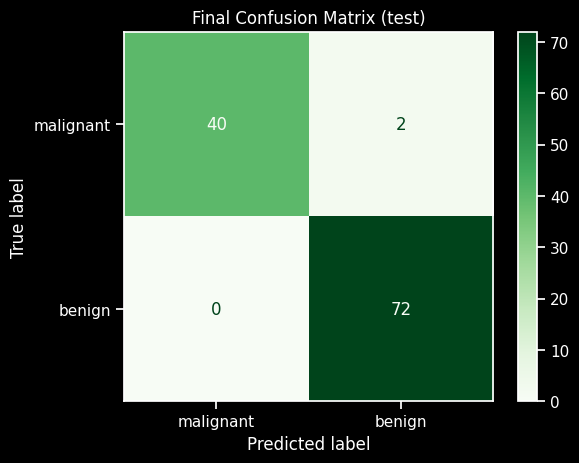

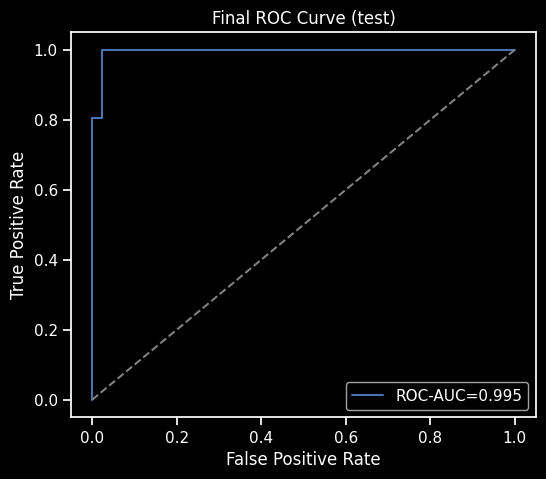

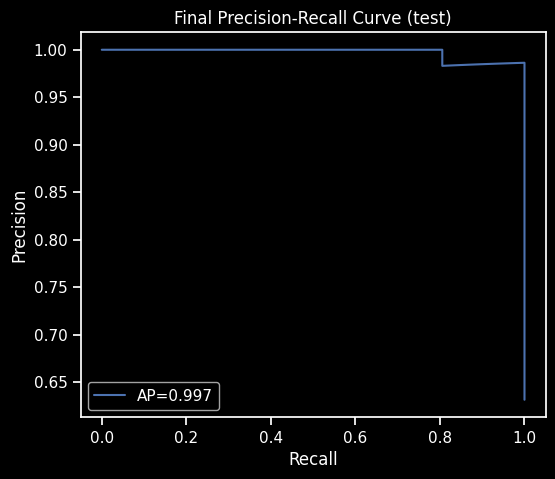

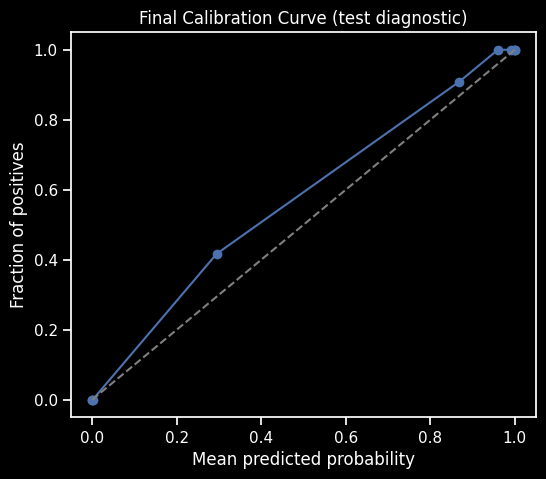


Classification report (test):
              precision    recall  f1-score   support

   malignant       1.00      0.95      0.98        42
      benign       0.97      1.00      0.99        72

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [ ]:
# Lock final choices based on CV + objective; retrain on full training set; report on untouched test once.

final_estimator = best_pipe  # from GridSearchCV (already trained on X_train)
final_threshold = chosen_threshold if "chosen_threshold" in globals() else 0.5

# Optionally use calibrated model if it improved Brier and you want calibrated probabilities.
use_calibrated = ("calibrator" in globals()) and ("brier_cal" in globals()) and ("brier_uncal" in globals()) and (brier_cal <= brier_uncal)

if use_calibrated:
    final_model = calibrator
    proba_test_final = proba_test_cal
    model_name = "Tuned LogisticRegression + Calibration"
else:
    final_model = final_estimator
    proba_test_final = final_estimator.predict_proba(X_test)[:, 1]
    model_name = "Tuned LogisticRegression"

pred_test_final = (proba_test_final >= final_threshold).astype(int)

cm_final = confusion_matrix(y_test, pred_test_final, labels=[0, 1])
acc_final = accuracy_score(y_test, pred_test_final)
prec_final = precision_score(y_test, pred_test_final, zero_division=0)
rec_final = recall_score(y_test, pred_test_final, zero_division=0)
spec_final = specificity_score(y_test, pred_test_final)
f1_final = f1_score(y_test, pred_test_final, zero_division=0)
roc_auc_final = roc_auc_score(y_test, proba_test_final)
ap_final = average_precision_score(y_test, proba_test_final)

print("Final model:", model_name)
print("Final threshold:", final_threshold)

final_metrics = pd.DataFrame([
    {"metric": "accuracy", "value": acc_final},
    {"metric": "precision (PPV) for y=1", "value": prec_final},
    {"metric": "recall/sensitivity for y=1", "value": rec_final},
    {"metric": "specificity for y=0", "value": spec_final},
    {"metric": "F1", "value": f1_final},
    {"metric": "ROC-AUC", "value": roc_auc_final},
    {"metric": "Average Precision (PR-AUC)", "value": ap_final},
])
display(final_metrics)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=[class_names[0], class_names[1]])
disp.plot(values_format="d", cmap="Greens")
plt.title("Final Confusion Matrix (test)")
plt.show()

# ROC/PR curves
fpr, tpr, _ = roc_curve(y_test, proba_test_final)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc_final:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final ROC Curve (test)")
plt.legend()
plt.show()

prec_curve, rec_curve, _ = precision_recall_curve(y_test, proba_test_final)
plt.figure(figsize=(6, 5))
plt.plot(rec_curve, prec_curve, label=f"AP={ap_final:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Final Precision-Recall Curve (test)")
plt.legend()
plt.show()

# Calibration diagnostic (if calibrated used, should be closer to diagonal)
prob_true_f, prob_pred_f = calibration_curve(y_test, proba_test_final, n_bins=10, strategy="quantile")
plt.figure(figsize=(6, 5))
plt.plot(prob_pred_f, prob_true_f, marker="o")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Final Calibration Curve (test diagnostic)")
plt.show()

print("\nClassification report (test):")
print(classification_report(y_test, pred_test_final, target_names=[class_names[0], class_names[1]], zero_division=0))


## 💡 Interpretation of the results

You trained a Tuned Logistic Regression model and evaluated it on the untouched test set using a decision threshold of 0.35. The results show exceptionally strong performance across multiple lenses.

Key performance at the chosen threshold:
- Accuracy: about 0.982
- ROC-AUC: about 0.995
- PR-AUC: about 0.997
- For the positive class (y=1): recall ≈ 1.000, precision ≈ 0.973
- For the negative class (y=0): specificity ≈ 0.952
- Overall F1: ≈ 0.986

Class-wise detail from the report (two classes: malignant and benign):
- Malignant (42 actual): precision 1.00, recall 0.95, F1 ≈ 0.98
- Benign (72 actual): precision 0.97, recall 1.00, F1 ≈ 0.99
- Overall accuracy ≈ 0.98; macro/weighted averages around 0.98–0.99

What the confusion matrix shows:
- 40 true malignant predicted as malignant (TP)
- 2 malignant predicted as benign (FN)
- 0 benign predicted as malignant (FP)
- 72 benign predicted as benign (TN)
- Thus, 2 errors in total, all from the malignant class; no false positives for the malignant class

Visual evidence across plots corroborates the numbers:
- Confusion matrix confirms the near-perfect performance with only two misclassifications (both in the malignant row)
- ROC curve demonstrates excellent discrimination, with the curve rising quickly toward the top-left and ROC-AUC ≈ 0.995
- Precision-Recall curve shows precision remaining high across recalls, with AP ≈ 0.997
- Calibration diagram indicates predicted probabilities are not perfectly aligned with observed frequencies, especially at mid-range probabilities; the blue calibration curve deviates from the diagonal, suggesting calibration could be beneficial if reliable probability estimates are important

Takeaways:
- The model provides very strong separation between malignant and benign cases and makes few errors at the 0.35 threshold.
- The combination of high ROC-AUC and PR-AUC indicates robust ranking and precision across operating points.
- While overall calibration is good, there is some miscalibration in mid-range probabilities, so if trustworthy probability estimates are critical, a calibration step could be considered in future steps.

## 🔎 Extensions & Comparisons

This step sanity-checks our chosen logistic regression model by benchmarking it against two common alternatives:

- **Linear SVM (calibrated)**: a strong linear classifier that often matches or beats logistic regression on ranking metrics, but doesn’t naturally output probabilities—so we calibrate it to get usable probability estimates.
- **Decision tree (shallow baseline)**: a simple non-linear model that can capture basic interactions but may be less stable and less well-calibrated.

### What you’re learning from the comparison

- **Discrimination vs. decision-making**: Metrics like **ROC-AUC** and **Average Precision (AP)** evaluate how well the model *ranks* positives above negatives across thresholds. Metrics like **Accuracy, F1, Precision, Recall** summarize performance at a *specific threshold* (here, 0.5).
- **Interpretability trade-offs**: Logistic regression gives a direct, global view of feature effects (via coefficients). A shallow tree can be intuitive locally but may behave differently across splits. Linear SVM is less interpretable in probabilistic terms unless calibrated.
- **Calibration matters**: In real deployments, you often need probabilities you can trust (for risk scoring, triage queues, or threshold tuning). Calibrating the SVM makes its outputs more comparable to logistic regression probabilities.

### Practical extensions to try (deployment-oriented)

- **L1 logistic regression for feature selection**: encourages many coefficients to become exactly zero, yielding a smaller, more interpretable feature set.
- **Alternative scaling (e.g., RobustScaler)**: if outliers dominate, robust scaling can make linear models behave more reliably than standard scaling.
- **Cost-sensitive evaluation / threshold control**: if missing positives is expensive (e.g., malignant cases), focus on **Recall/AP** and choose a threshold that matches the operational priority rather than defaulting to 0.5.

In [ ]:
# Compare logistic regression to Linear SVM and a simple tree baseline.

models = {
    "LogReg (final)": final_model,
    "LinearSVC (calibrated)": CalibratedClassifierCV(
        estimator=Pipeline([
            ("scaler", StandardScaler()),
            ("svm", LinearSVC(random_state=RANDOM_STATE))
        ]),
        method="sigmoid",
        cv=5
    ),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4)
}

rows = []
for name, model in models.items():
    if name == "LogReg (final)":
        # already fit (on train) if final_model is calibrator; otherwise fit to be safe
        if not hasattr(model, "classes_"):
            model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:, 1]
    else:
        model.fit(X_train, y_train)
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test)[:, 1]
        else:
            # fallback (shouldn't happen here)
            scores = model.decision_function(X_test)
            proba = 1 / (1 + np.exp(-scores))

    pred = (proba >= 0.5).astype(int)
    rows.append({
        "model": name,
        "ROC-AUC": roc_auc_score(y_test, proba),
        "AP": average_precision_score(y_test, proba),
        "Accuracy": accuracy_score(y_test, pred),
        "F1": f1_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "Precision": precision_score(y_test, pred, zero_division=0),
    })

compare = pd.DataFrame(rows).sort_values("ROC-AUC", ascending=False)
display(compare)

print("\nNotes for extensions:")
print("- Try L1 logistic regression for feature selection; inspect how many coefficients become exactly zero.")
print("- Try RobustScaler instead of StandardScaler if outliers dominate.")
print("- If malignant sensitivity is the priority, consider flipping the target so malignant=1 and optimize recall/AP accordingly.")


,model,ROC-AUC,AP,Accuracy,F1,Recall,Precision
0,LogReg (final),0.995370,0.997065,0.982456,0.986111,0.986111,0.986111
1,LinearSVC (calibrated),0.993717,0.995974,0.973684,0.979592,1.000000,0.960000
2,DecisionTree,0.934193,0.941940,0.938596,0.951049,0.944444,0.957746



Notes for extensions:
- Try L1 logistic regression for feature selection; inspect how many coefficients become exactly zero.
- Try RobustScaler instead of StandardScaler if outliers dominate.
- If malignant sensitivity is the priority, consider flipping the target so malignant=1 and optimize recall/AP accordingly.


## 💡 Interpretation of the results

In this cell, you compared three models on both ranking performance and threshold-based metrics at a 0.5 decision threshold.

Key takeaways by model
- LogReg (final): Leads on ranking metrics, with ROC-AUC around 0.995 and AP near 0.997. At the 0.5 threshold, it also achieves the strongest overall accuracy (about 0.982) and very high F1, recall, and precision (around 0.986). This model provides the best balance between discriminative power and practical classification performance.
- LinearSVC (calibrated): Comes close to LogReg on ranking metrics but shines in recall, hitting 1.0, while precision remains slightly below LogReg (about 0.96). In other words, it detects all positives but at the cost of more false positives, slightly lowering overall precision.
- DecisionTree: Clearly weaker across both ranking and threshold-based metrics. ROC-AUC around 0.934 and AP around 0.942; accuracy near 0.939; F1 and recall around 0.95 with precision around 0.958. This indicates poorer discrimination and a less favorable balance at the chosen threshold.

How to read the results together
- Ranking metrics (ROC-AUC and AP) measure how well a model separates positives from negatives across all thresholds. Higher values favor LogReg, indicating superior ranking capability.
- Threshold-based metrics (Accuracy, F1, Recall, Precision) at 0.5 reflect practical performance for a concrete decision boundary. Here, LogReg again comes out ahead overall, while LinearSVC achieves perfect recall but with a dip in precision, and DecisionTree trails the others.